In [89]:
import utils
import seaborn as sn

from Code import evaluations

## Choosing features

In [90]:
initial_df = utils.task1_df(isEDA=True)
_, _, df30s = utils.task4_df(isEDA=True)
df30s.head()

,TrackID,zero_cross_rate_mean,zero_cross_rate_std,rmse_mean,rmse_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,spectral_rolloff_mean,...,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,mfcc_12_std,GenreID,Genre
0,0,0.131656,0.051042,0.234452,0.069776,2569.255823,634.389892,2559.529362,417.736160,5351.909304,...,10.917519,9.436494,9.818374,7.884112,7.231014,8.026523,7.281337,6.818096,0,pop
1,1,0.099747,0.054401,0.243250,0.081652,2844.070408,953.593356,3219.148148,436.932356,6839.566975,...,13.182616,12.191261,11.272436,9.856543,10.003786,10.398938,8.929573,9.131061,0,pop
2,2,0.096015,0.060390,0.138146,0.050329,2765.648135,916.797020,3222.697319,417.432500,6873.341771,...,11.026413,14.622502,11.424296,13.402919,9.898433,9.893081,10.140719,8.330488,0,pop
3,3,0.183106,0.088115,0.212939,0.075027,3634.106564,820.191199,3134.284752,312.987674,7534.996104,...,11.044224,12.229629,12.219382,11.645808,11.426618,9.012418,10.227400,9.494127,0,pop
4,5,0.161897,0.084610,0.259807,0.096101,3671.260489,937.024680,3295.553789,333.396129,7879.044023,...,10.348630,11.043411,9.928480,8.211914,8.241311,9.336305,8.607124,7.269691,0,pop


### 1. Correlations

In [91]:
highest_corr = (df30s
                .drop(columns=['Genre', 'TrackID'])
                .corr().GenreID
                .drop('GenreID')
                .abs()
                .sort_values()
                .tail())
highest_corr

mfcc_2_mean               0.333709
mfcc_1_mean               0.344760
spectral_rolloff_mean     0.384887
spectral_centroid_mean    0.399847
zero_cross_rate_mean      0.413442
Name: GenreID, dtype: float64

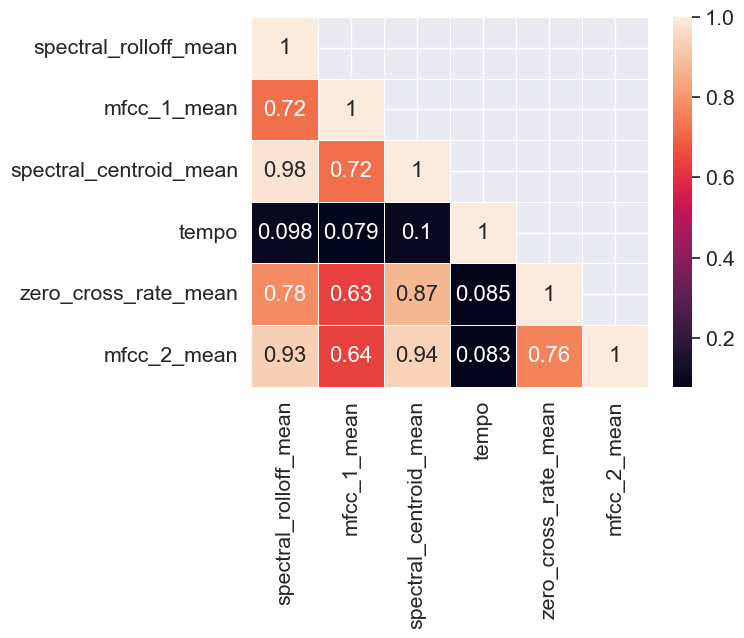

In [92]:
candidates = list(set(highest_corr.index.values).union(initial_df.drop(columns='Genre').columns.values))
utils.plot_corr(df30s[candidates], abs=True)

In [93]:
correlation_picked_features = ["zero_cross_rate_mean", "spectral_rolloff_mean", "mfcc_1_mean", "tempo" ]

In [94]:
# TODO add code to test and plot all possibilities 

# kNN design

In [95]:
df = utils.task3_df(pickedFeatures=correlation_picked_features)
df.head()

,zero_cross_rate_mean,spectral_rolloff_mean,mfcc_1_mean,tempo,Type,GenreID
0,0.131656,5351.909304,9.675074,117.453835,Train,0
1,0.099747,6839.566975,-63.635056,107.666016,Train,0
2,0.096015,6873.341771,-119.346458,161.499023,Train,0
3,0.183106,7534.996104,-26.936581,117.453835,Train,0
4,0.161897,7879.044023,-8.531343,129.199219,Train,0


In [96]:
X_train_scaled, y_train, X_test_scaled, y_test = utils.train_val_split(df)

In [97]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, weights='distance')
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(weights='distance')

In [98]:
y_pred = knn.predict(X_test_scaled)

## Evaluation

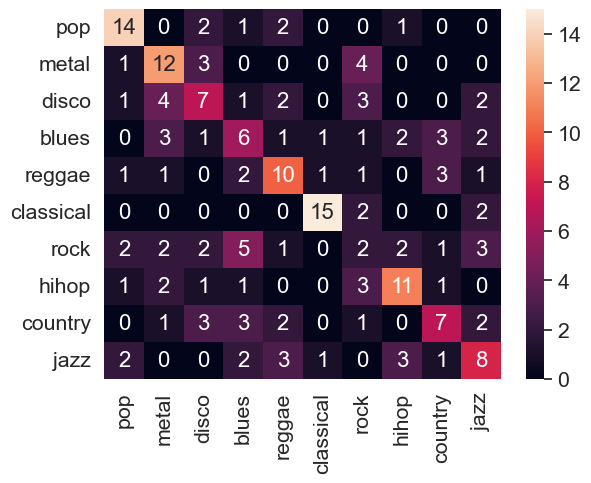

In [99]:
evaluations.conf_matrix(y_pred, y_test)

In [100]:
p = evaluations.multiclass_performance_metrics(y_pred, y_test)
print(f"Accuracy : {p.tp.sum()/len(y_pred)}\n"
      f"Macro F1 score : {p.F1Score.mean()}")
p

Accuracy : 0.46464646464646464
Macro F1 score : 0.4622483646873891


,tp,tn,fp,fn,F1Score
pop,14,170,8,6,0.666667
metal,12,165,13,8,0.533333
disco,7,166,12,13,0.358974
blues,6,163,15,14,0.292683
reggae,10,167,11,10,0.487805
classical,15,176,3,4,0.810811
rock,2,163,15,18,0.108108
hihop,11,170,8,9,0.564103
country,7,170,9,12,0.400000
jazz,8,166,12,12,0.400000


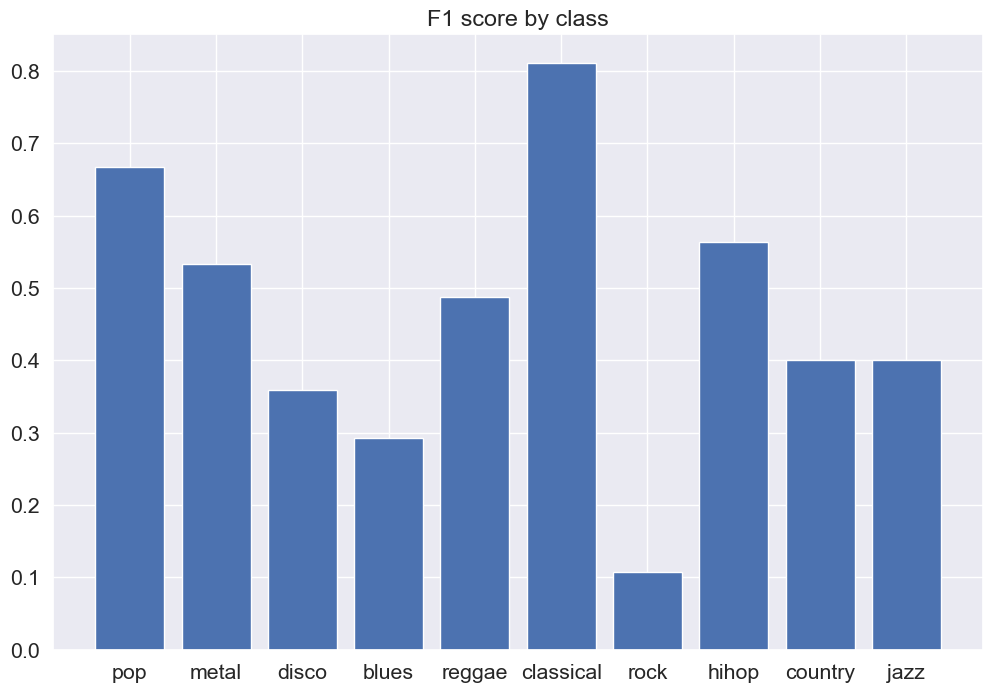

In [101]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(utils.genreNames, p.F1Score)
plt.title("F1 score by class")
plt.show()